In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from neuroguard.commons.constant import DATASETS_FOLDER
from neuroguard.data.data_loader.eeg_data_extractor import EEGDataExtractor
from neuroguard.data.eeg_triplet_dataset import EEGTripletDataset
from neuroguard.commons.constant import NUM_OF_ELECTRODES
from neuroguard.models.similarity.eegnet import EEGNetEmbeddingModel
from neuroguard.utils.engine import train_eegnet, generate_embeddings_2d
from neuroguard.utils.helpers import train_test_split, set_seeds, create_user_profiles, predict_ids
from neuroguard.utils.visualisations import plot_loss, plot_embeddings_2d, plot_embeddings_by_participant, plot_UMAP, plot_PCA, plot_tSNE, plot_LDA, plot_confusion_matrix, plot_sample_signal, plot_sample_signals, plot_first_channel, plot_PSD
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

# Loading data


In [ ]:
DATA_DIR = f"{DATASETS_FOLDER}/Kolory/"

extractor = EEGDataExtractor(data_dir=DATA_DIR)
eeg_df, participants_info = extractor.extract_dataframe()

# Exploratory data analysis


In [4]:
eeg_df.head()

,participant_id,epoch,label
0,011595b1@1651,"[[1.5994905899983496e-06, 4.660259780289654e-0...",gray
1,011595b1@1651,"[[3.2936710911247503e-06, 3.745427511069207e-0...",green
2,011595b1@1651,"[[4.327731927482567e-06, 2.515285592381088e-06...",gray
3,011595b1@1651,"[[1.7759480686267016e-06, -3.0099938072414544e...",red
4,011595b1@1651,"[[4.0924612078715145e-06, 4.532130983695527e-0...",gray


In [5]:
eeg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6960 entries, 0 to 6959
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   participant_id  6960 non-null   object
 1   epoch           6960 non-null   object
 2   label           6960 non-null   object
dtypes: object(3)
memory usage: 163.3+ KB


In [6]:
eeg_df.describe()

,participant_id,epoch,label
count,6960,6960,6960
unique,30,6960,6
top,011595b1@1651,"[[7.765466320882314e-06, 7.001198703267933e-06...",gray
freq,232,1,3480


In [7]:
eeg_df['label'].value_counts()

label
gray      3480
green      840
red        840
yellow     840
blue       840
break      120
Name: count, dtype: int64

In [10]:
sample = eeg_df['epoch'].iloc[0]
sample.shape

(4, 751)

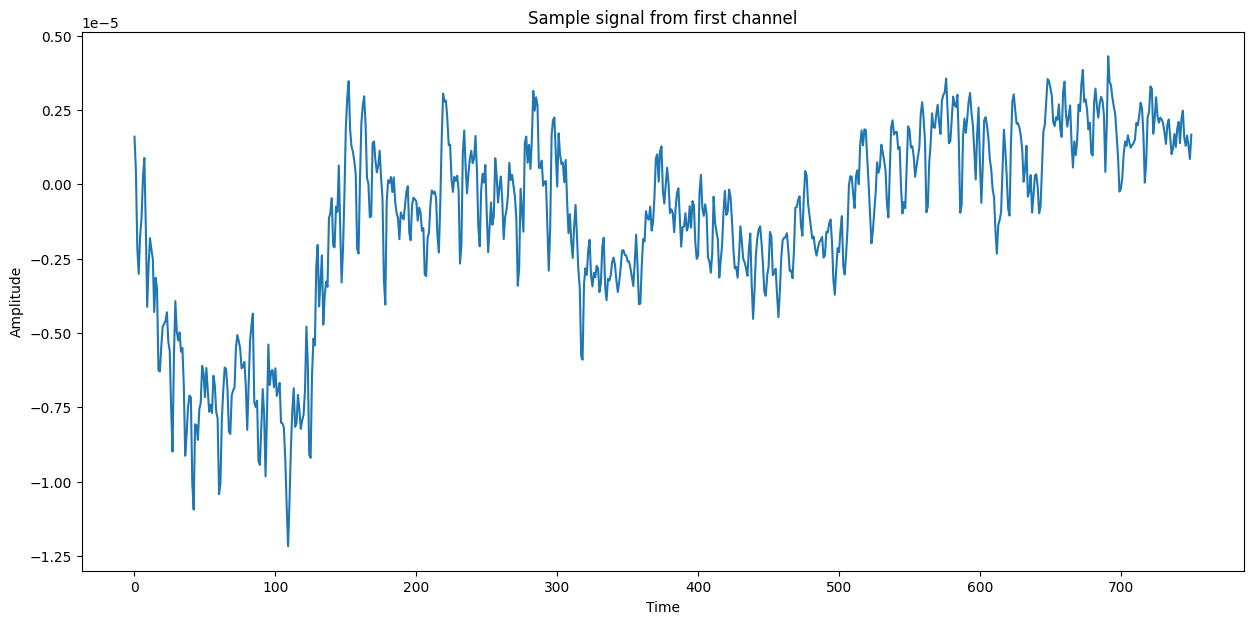

In [12]:
plot_sample_signal(sample)

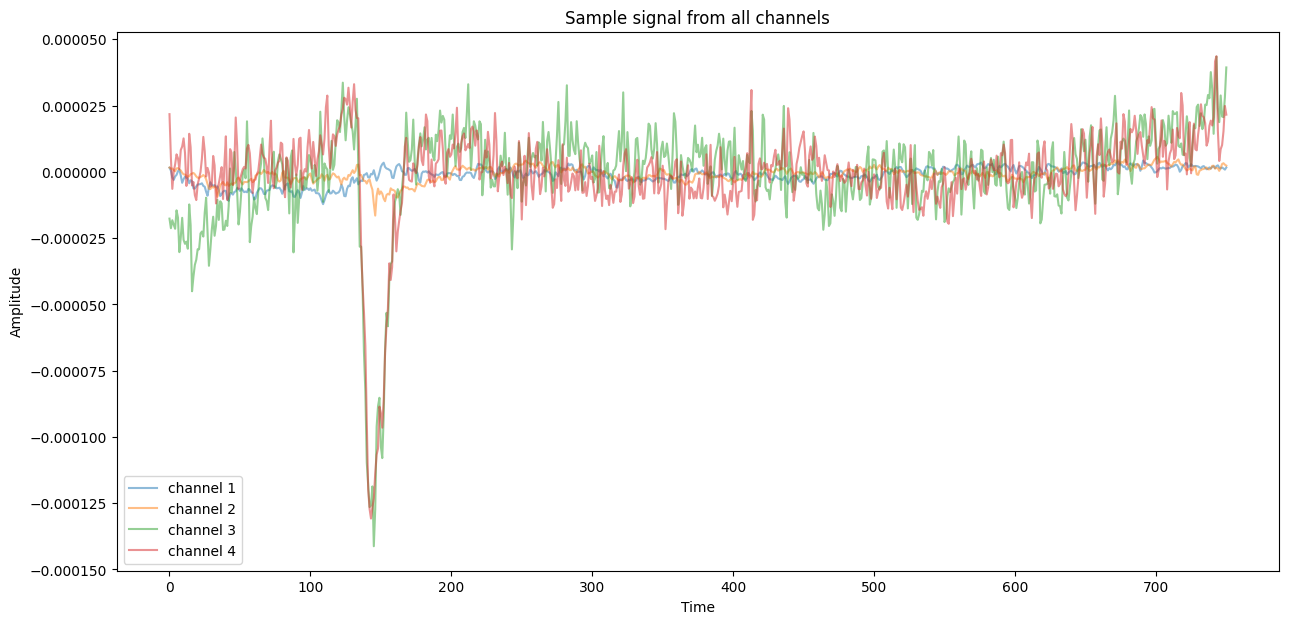

In [13]:
plot_sample_signals(sample)

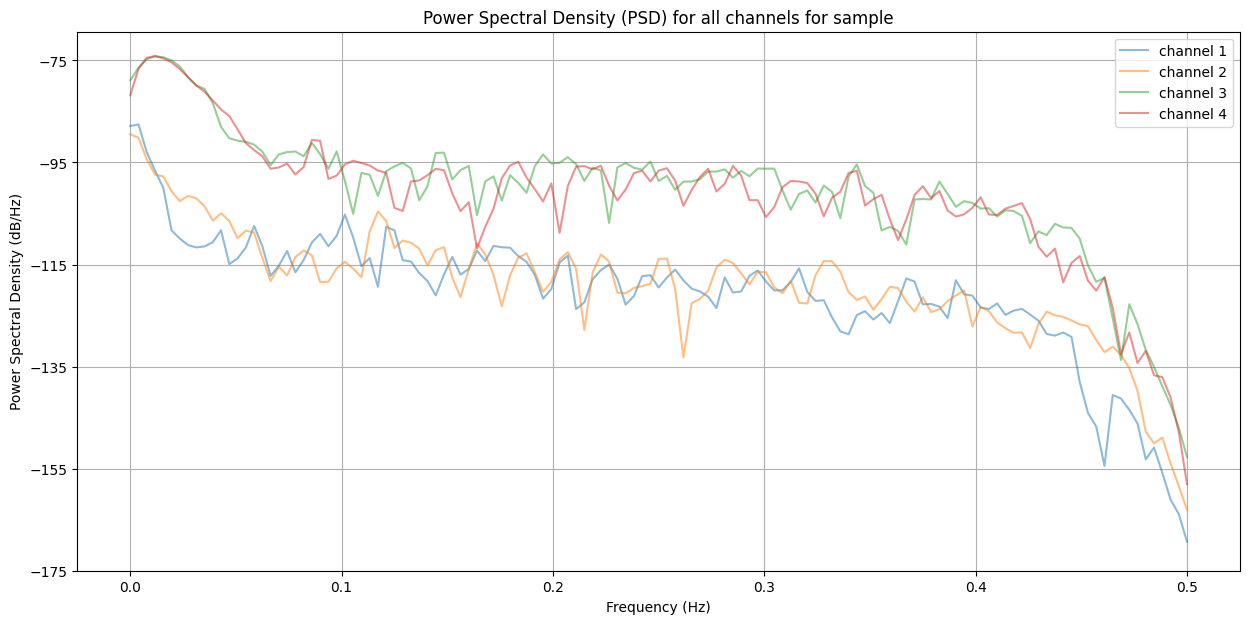

In [14]:
plot_PSD(sample)

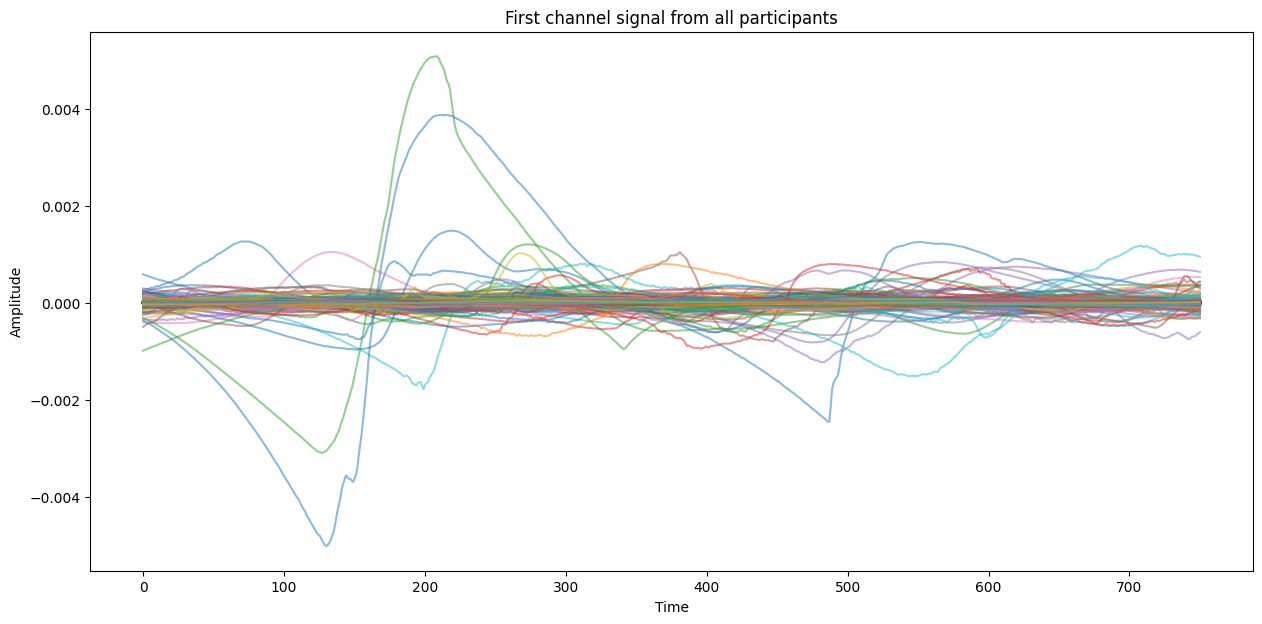

In [15]:
plot_first_channel(eeg_df)

# Preparing data


In [16]:
set_seeds()
train_df, test_df, train_participants, test_participants = train_test_split_eeg(
    eeg_df, test_size=0.25
)

train_dataset = EEGTripletDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


In [17]:
test_dataset = EEGTripletDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Loading model


In [18]:
print(f"Number of samples in train_dataset: {len(train_dataset)}")

sample_anchor, sample_positive, sample_negative = train_dataset[0]
print(f"Shape of anchor: {sample_anchor.shape}")
print(f"Shape of positive: {sample_positive.shape}")
print(f"Shape of negative: {sample_negative.shape}")

Number of samples in train_dataset: 5104
Shape of anchor: torch.Size([1, 4, 751])
Shape of positive: torch.Size([1, 4, 751])
Shape of negative: torch.Size([1, 4, 751])


In [19]:
eegnet_model = EEGNetEmbeddingModel(
    num_channels=4, num_time_points=751, num_classes=32, embedding_dimension=32
)

triplet_loss = torch.nn.TripletMarginLoss(margin=0.05)
eegnet_optimizer = torch.optim.Adam(eegnet_model.parameters(), lr=1e-3)

num_epochs = 40

In [20]:
for anchor, positive, negative in train_loader:
    print(f"Anchor shape: {anchor.shape}")
    print(f"Positive shape: {positive.shape}")
    print(f"Negative shape: {negative.shape}")
    break  # Print shapes for the first batch only

Anchor shape: torch.Size([8, 1, 4, 751])
Positive shape: torch.Size([8, 1, 4, 751])
Negative shape: torch.Size([8, 1, 4, 751])


In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
eegnet_model = eegnet_model.to(device)

In [22]:
train_history = train_eegnet(
    eegnet_model, train_loader, eegnet_optimizer, device, triplet_loss, num_epochs
)

C:\Users\basia\Desktop\Neuroguard\.venv\Lib\site-packages\torch\nn\modules\conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv2d(


Epoch 1/40 | Train Loss: 0.1749
Epoch 2/40 | Train Loss: 0.0854
Epoch 3/40 | Train Loss: 0.0705
Epoch 4/40 | Train Loss: 0.0636
Epoch 5/40 | Train Loss: 0.0550
Epoch 6/40 | Train Loss: 0.0422
Epoch 7/40 | Train Loss: 0.0369
Epoch 8/40 | Train Loss: 0.0341
Epoch 9/40 | Train Loss: 0.0343
Epoch 10/40 | Train Loss: 0.0320
Epoch 11/40 | Train Loss: 0.0308
Epoch 12/40 | Train Loss: 0.0282
Epoch 13/40 | Train Loss: 0.0278
Epoch 14/40 | Train Loss: 0.0270
Epoch 15/40 | Train Loss: 0.0235
Epoch 16/40 | Train Loss: 0.0250
Epoch 17/40 | Train Loss: 0.0239
Epoch 18/40 | Train Loss: 0.0220
Epoch 19/40 | Train Loss: 0.0227
Epoch 20/40 | Train Loss: 0.0216
Epoch 21/40 | Train Loss: 0.0224
Epoch 22/40 | Train Loss: 0.0201
Epoch 23/40 | Train Loss: 0.0195
Epoch 24/40 | Train Loss: 0.0189
Epoch 25/40 | Train Loss: 0.0196
Epoch 26/40 | Train Loss: 0.0190
Epoch 27/40 | Train Loss: 0.0197
Epoch 28/40 | Train Loss: 0.0189
Epoch 29/40 | Train Loss: 0.0182
Epoch 30/40 | Train Loss: 0.0184
Epoch 31/40 | Train

In [23]:
model_save_path = f"./eegnet_model.pth"
torch.save(eegnet_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./eegnet_model.pth


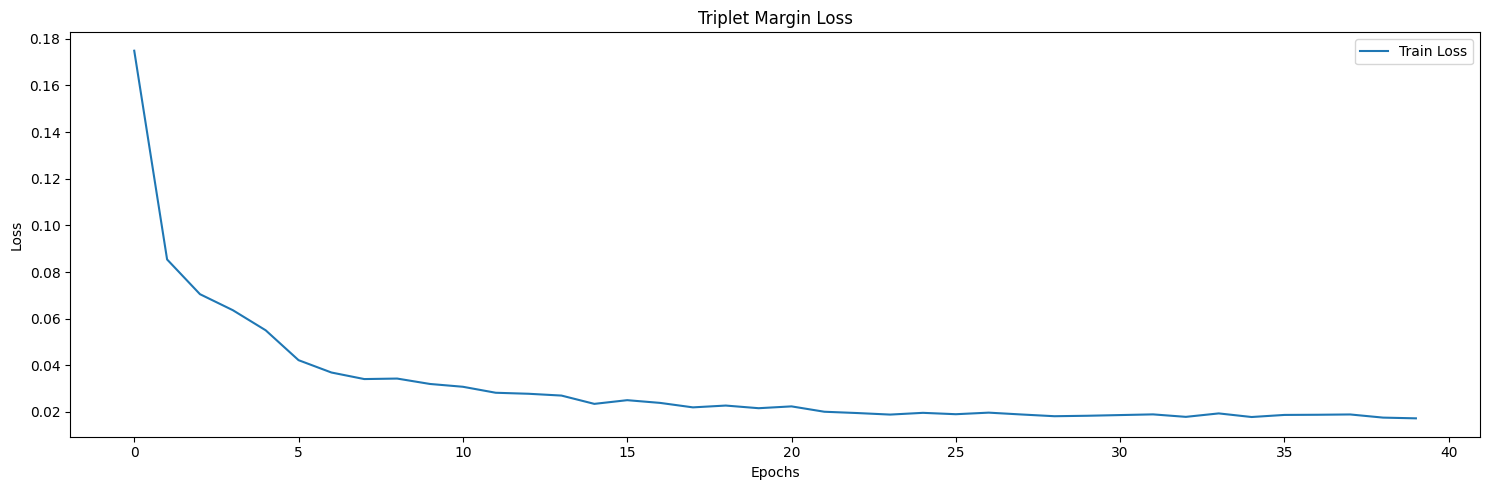

In [24]:
plot_loss(train_history)

## Embeddings visualization


In [25]:
embeddings_2d = generate_embeddings_2d(eegnet_model, test_loader, device)
print(f"Generated test embeddings with shape: {embeddings_2d.shape}")

Generated test embeddings with shape: (1856, 32)


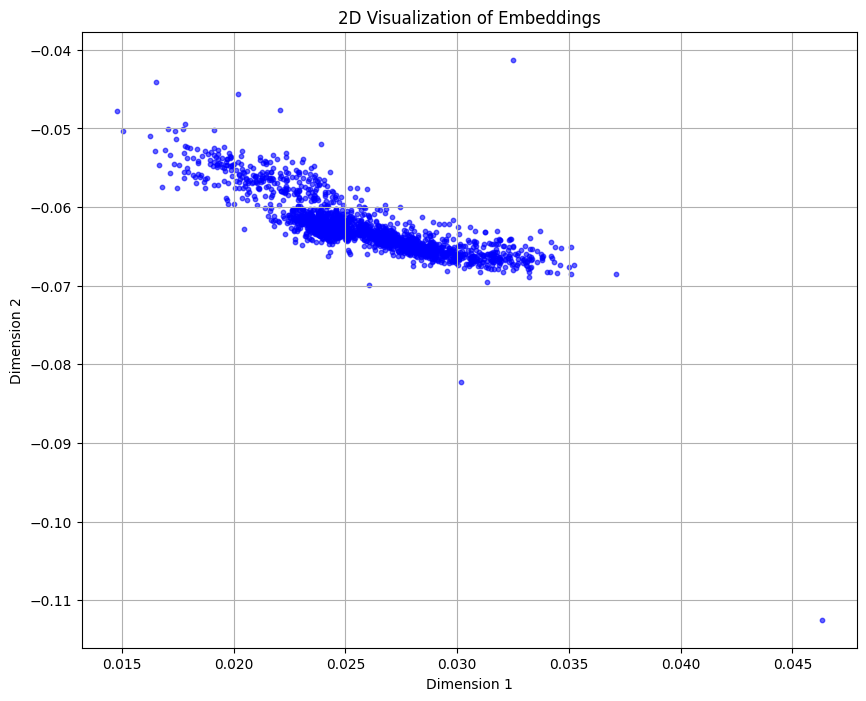

In [26]:
plot_embeddings_2d(embeddings_2d)

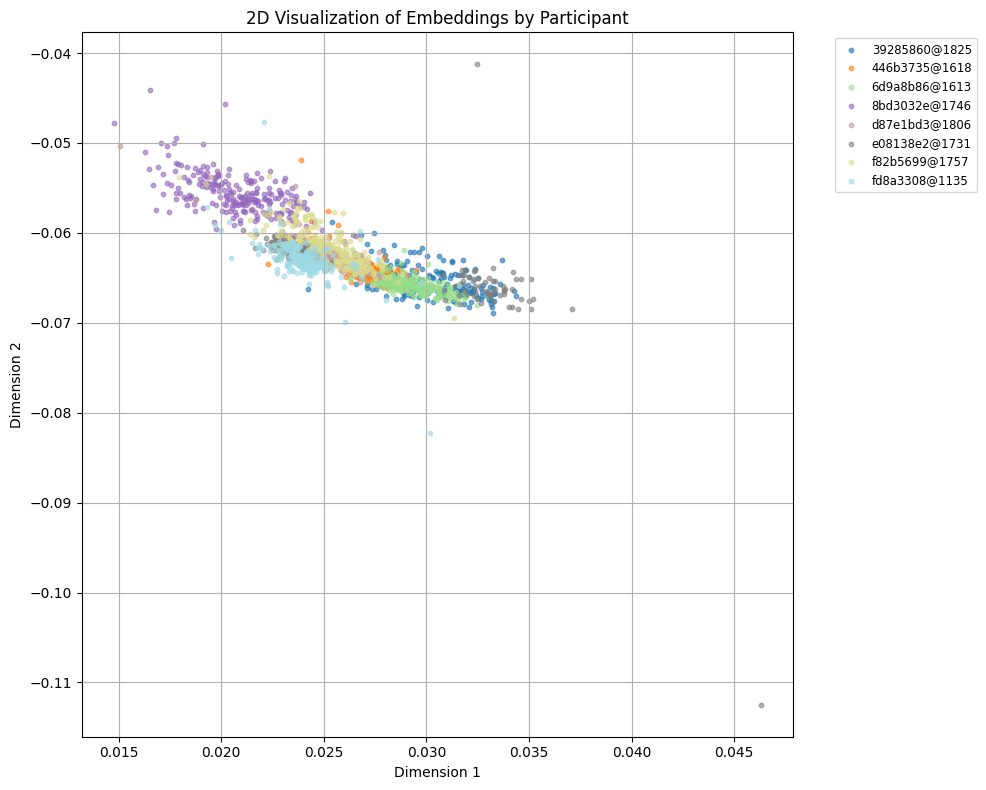

In [27]:
participant_ids = test_participants['participant_id']
plot_embeddings_by_participant(embeddings_2d, participant_ids)

C:\Users\basia\Desktop\Neuroguard\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


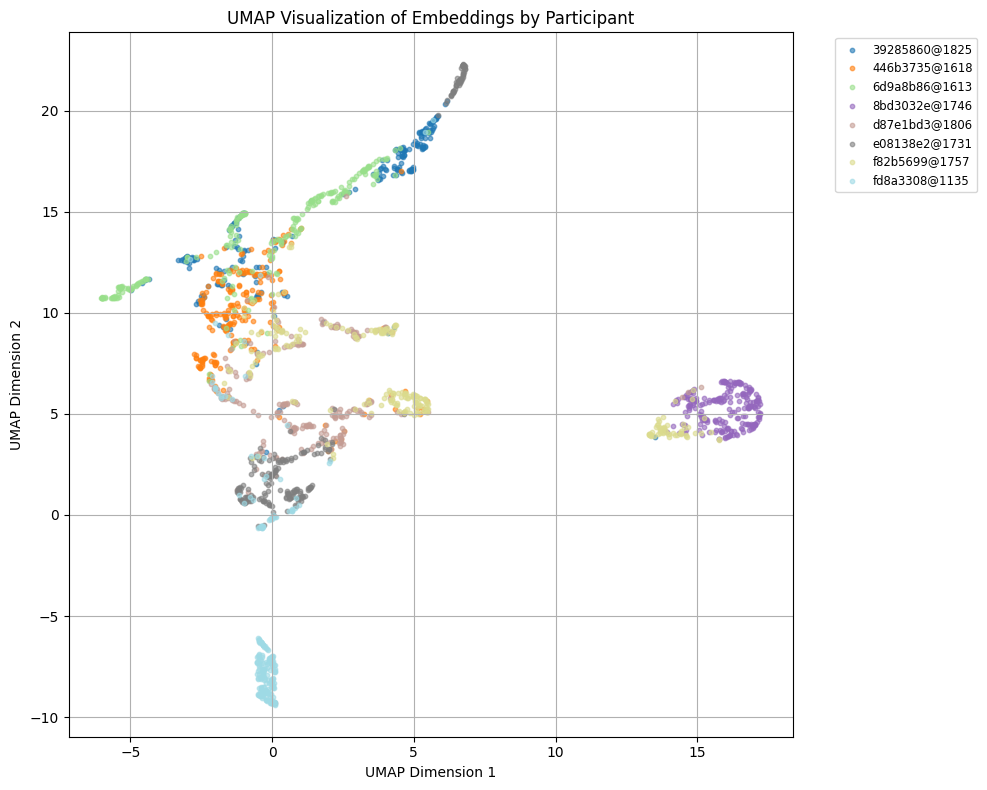

In [28]:
plot_UMAP(embeddings_2d, participant_ids)

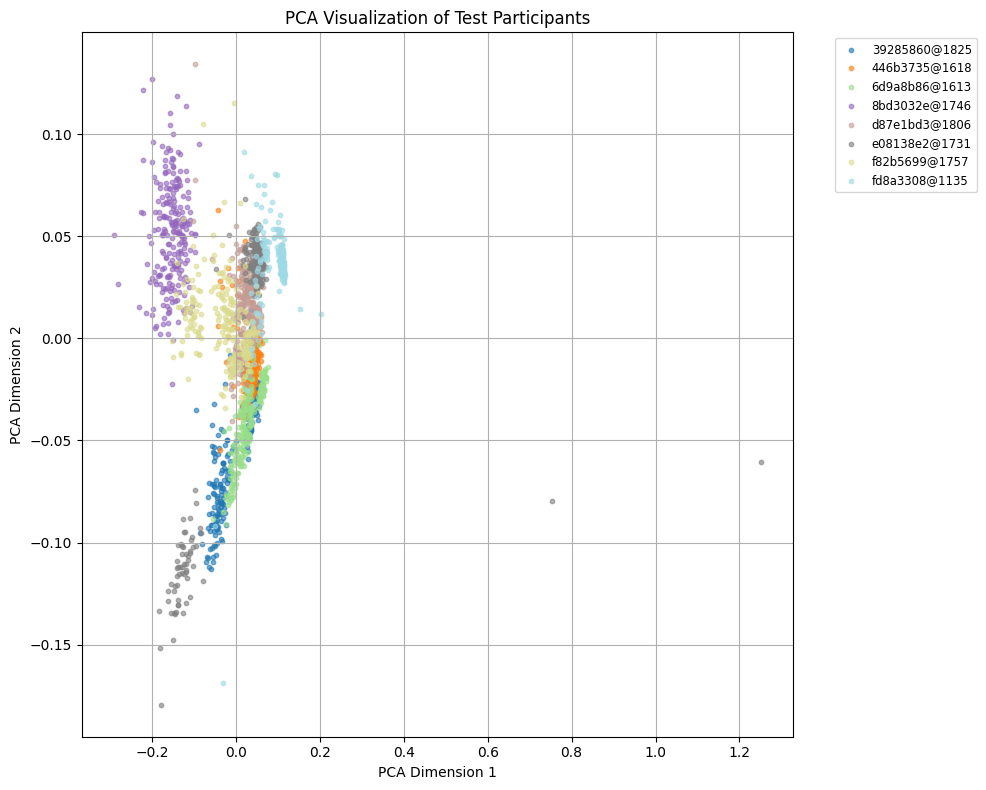

In [29]:
plot_PCA(embeddings_2d, participant_ids)

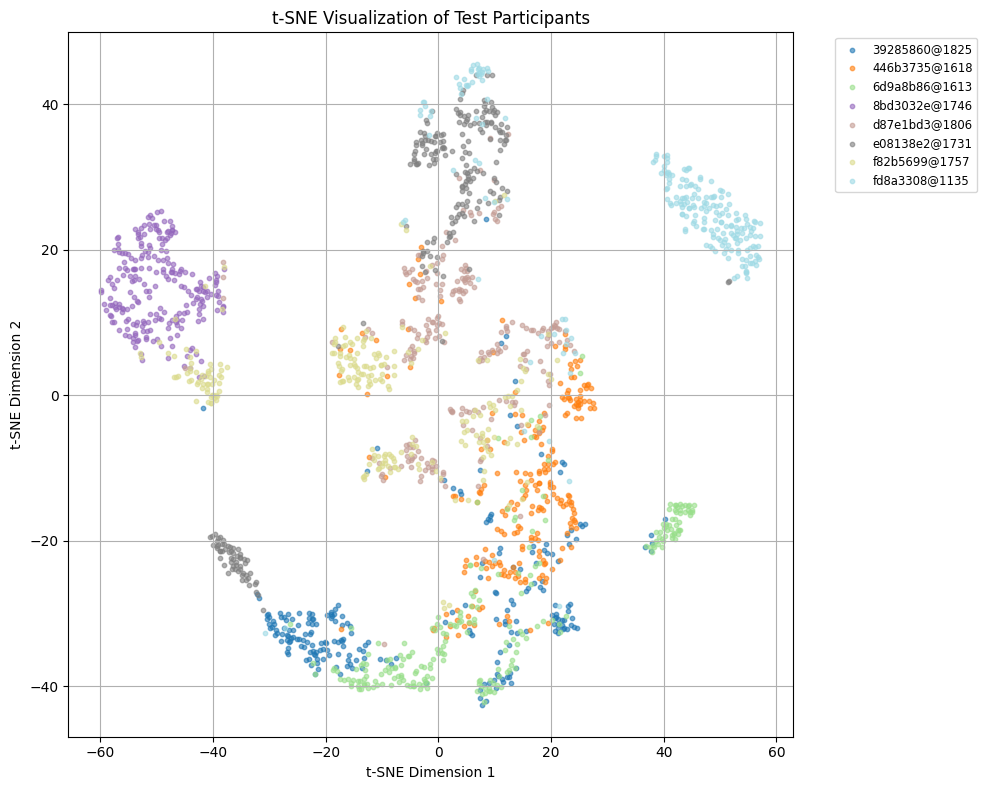

In [30]:
plot_tSNE(embeddings_2d, participant_ids)

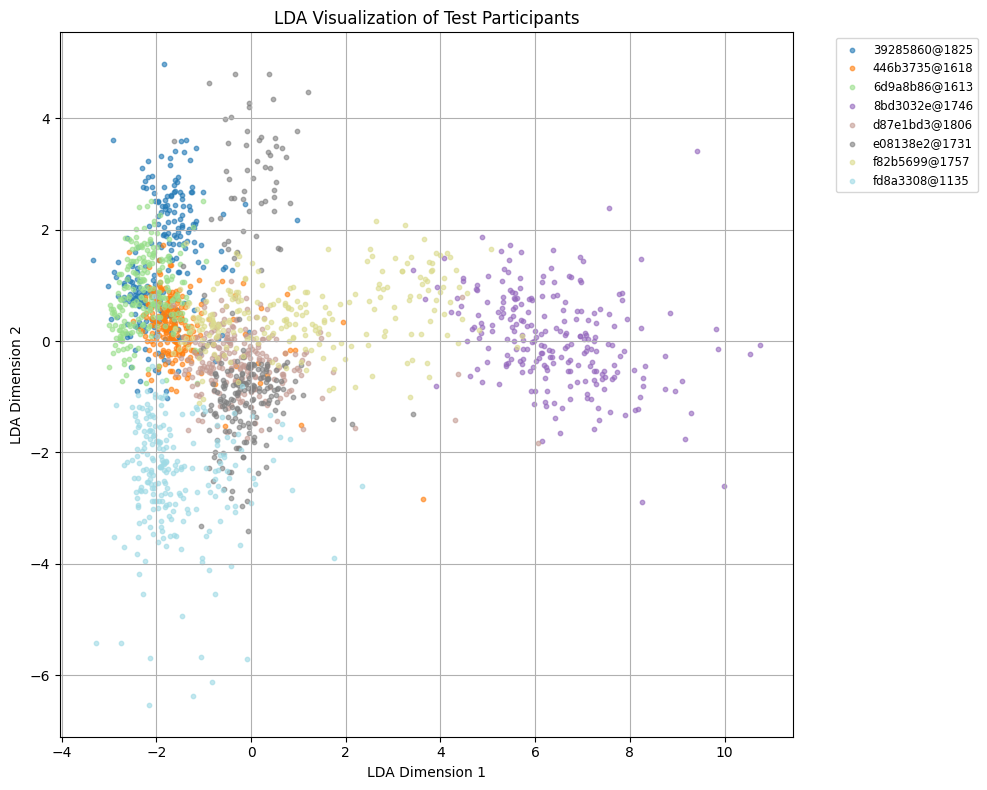

In [31]:
plot_LDA(embeddings_2d, participant_ids)

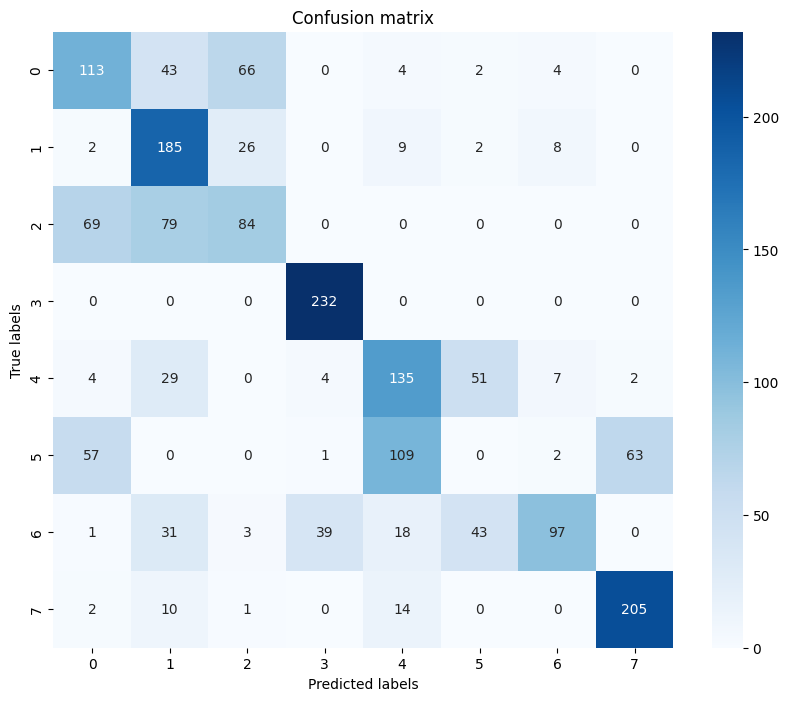

In [32]:
user_profiles = create_user_profiles(embeddings_2d, participant_ids)
predicted_ids = predict_ids(embeddings_2d, user_profiles)
conf_matrix = confusion_matrix(participant_ids, predicted_ids)
plot_confusion_matrix(conf_matrix)

In [33]:
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.566
